<a href="https://colab.research.google.com/github/ndirani/DataScience_ArtificialIntelligence_Utils/blob/master/LSTM_Alizee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight

def norm(f_vals):
    """
    Calcul de la norme d'un vecteur à partir de ses composantes.
    """
    # Calcule la norme à partir des composantes du vecteur.
    norm = np.sqrt(np.sum(np.abs(f_vals)**2))

    return norm

# Charge les données à partir d'un fichier CSV.
df = pd.read_csv("Alizee4nage_july.csv", sep =";")
df.head()


df["AccX"] = df["AccX"].str.replace(',', '.')
df["AccY"] = df["AccY"].str.replace(',', '.')
df["AccZ"] = df["AccZ"].str.replace(',', '.')

df["AccX"] = df["AccX"].astype(float)
df["AccY"] = df["AccY"].astype(float)
df["AccZ"] = df["AccZ"].astype(float)


# Sélectionne les colonnes à utiliser pour le calcul de la norme.
cols_Acc = ['AccX', 'AccY', 'AccZ']
cols_Gyr = ['GyrX', 'GyrY', 'GyrZ']

# Calcule la norme pour chaque ligne du DataFrame.
df['norm_Acc'] = df[cols_Acc].apply(lambda x: norm(x), axis=1)
df['norm_Gyr'] = df[cols_Gyr].apply(lambda x: norm(x), axis=1)

# Enregistre les résultats dans un nouveau fichier CSV.
df.to_csv('norms_Acc.csv', index=False)
#df.to_csv('norms_Gyr.csv', index=False)
df.head()


,Timestamp,Fix,Lat,Lon,Alt,pAcc,Mag,Speed,sAcc,Heading,Battery,AccX,AccY,AccZ,GyrX,GyrY,GyrZ,Swim_class,norm_Acc,norm_Gyr
0,10:24:14.428,False,0,0,0,0,0,0,0,0,"4,13",837.408,-257.664,-130.296,6370,22470,26950,Out,885.787753,35662.028826
1,10:24:14.523,False,0,0,0,0,0,0,0,0,"4,13",732.488,-327.448,182.024,-23450,-42910,-50050,Out,822.735437,69972.659661
2,10:24:14.631,False,0,0,0,0,0,0,0,0,"4,12625",734.440,-355.996,-218.380,35280,95690,11480,Out,844.881702,102630.623597
3,10:24:14.732,False,0,0,0,0,0,0,0,0,"4,12625",933.056,-423.584,23.912,78330,80010,21350,Out,1024.982287,113986.891790
4,10:24:14.826,False,0,0,0,0,0,0,0,0,"4,12875",866.932,-313.296,-340.380,6720,48860,23940,Out,982.641349,54823.184876


In [2]:
# Extract the acceleration components in X, Y, and Z directions
acc_x = df['AccX']
acc_y = df['AccY']
acc_z = df['AccZ']

# Calculate the magnitude of acceleration using the Euclidean norm formula
magnitude = np.sqrt(acc_x**2 + acc_y**2 + acc_z**2)

# Normalize the acceleration components by dividing each component by the magnitude
normalized_acc_x = acc_x / magnitude
normalized_acc_y = acc_y / magnitude
normalized_acc_z = acc_z / magnitude

# Add the magnitude and normalized acceleration columns to the DataFrame
df['Magnitude'] = magnitude
df['NormalizedAccX'] = normalized_acc_x
df['NormalizedAccY'] = normalized_acc_y
df['NormalizedAccZ'] = normalized_acc_z

# Print the updated DataFrame
#print(df.head())

df.to_csv('updated_data.csv', index=False)
df.head()


,Timestamp,Fix,Lat,Lon,Alt,pAcc,Mag,Speed,sAcc,Heading,...,GyrX,GyrY,GyrZ,Swim_class,norm_Acc,norm_Gyr,Magnitude,NormalizedAccX,NormalizedAccY,NormalizedAccZ
0,10:24:14.428,False,0,0,0,0,0,0,0,0,...,6370,22470,26950,Out,885.787753,35662.028826,885.787753,0.945382,-0.290887,-0.147096
1,10:24:14.523,False,0,0,0,0,0,0,0,0,...,-23450,-42910,-50050,Out,822.735437,69972.659661,822.735437,0.890308,-0.397999,0.221242
2,10:24:14.631,False,0,0,0,0,0,0,0,0,...,35280,95690,11480,Out,844.881702,102630.623597,844.881702,0.869281,-0.421356,-0.258474
3,10:24:14.732,False,0,0,0,0,0,0,0,0,...,78330,80010,21350,Out,1024.982287,113986.891790,1024.982287,0.910314,-0.413260,0.023329
4,10:24:14.826,False,0,0,0,0,0,0,0,0,...,6720,48860,23940,Out,982.641349,54823.184876,982.641349,0.882247,-0.318830,-0.346393


In [3]:
from scipy.spatial.transform import Rotation as R
import datetime

# convert time values to numeric values
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%H:%M:%S.%f').astype(int) / 10**9

# print the updated dataframe
print(df.head())

time = df["Timestamp"].values
acceleration = df[["AccX", "AccY", "AccZ"]].values.astype(float)
gyroscope = df[["GyrX", "GyrY", "GyrZ"]].values.astype(float)

# Initialize variables
q = np.array([1, 0, 0, 0])
integral_error = np.array([0, 0, 0])

# Create empty lists to store the fused data
fused_acceleration = []
fused_gyroscope = []
fused_orientation = []

def q_mult(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1*w2 - x1*x2 - y1*y2 - z1*z2
    x = w1*x2 + x1*w2 + y1*z2 - z1*y2
    y = w1*y2 - x1*z2 + y1*w2 + z1*x2
    z = w1*z2 + x1*y2 - y1*x2 + z1*w2
    return np.array([w, x, y, z])

def q_conj(q):
    """ Calcule le conjugé d'un quaternion """
    w, x, y, z = q
    return np.array([w, -x, -y, -z])

# Loop through each data point
for i in range(len(df)):
    # Normalize acceleration values
    norm_acc = np.linalg.norm(acceleration[i])
    if norm_acc == 0:
        acceleration[i] = [0, 0, 0]
    else:
        acceleration[i] /= norm_acc

    # Normalize gyroscope values
    norm_gyro = np.linalg.norm(gyroscope[i])
    if norm_gyro == 0:
        gyroscope[i] = [0, 0, 0]
    else:
        gyroscope[i] /= norm_gyro

    # Convert gyroscope values to radians per second
    gyroscope_rad = np.radians(gyroscope[i])

    # Calculate the predicted orientation using the gyroscope data
    q_predicted = q + 0.5 * q_mult(q, np.hstack([0, gyroscope_rad])) * (time[i] - time[i-1])
    q_predicted /= np.linalg.norm(q_predicted)
    #print(time[i] - time[i-1])
    #print(time[i])
    # Calculate the error between the predicted orientation and the measured orientation
    q_measured = np.array([np.sqrt(0.5), 0, np.sqrt(0.5), 0])
    q_error = q_mult(q_predicted, q_conj(q_measured))

    # Integrate the error over time to get the integral error
    integral_error = integral_error.astype('float64')
    integral_error += q_error[1:] * (time[i] - time[i-1])

    # Calculate the correction term using the integral error
    correction = np.hstack([0, 2 * 1 * integral_error])

    # Apply the correction term to the predicted orientation to get the corrected orientation
    q_corrected = q_mult(q_predicted, correction)
    q_corrected /= np.linalg.norm(q_corrected)

    # Use the accelerometer data to further correct the orientation
    gravity = np.array([0, 0, -1])
    acceleration_norm = np.linalg.norm(acceleration[i])
    if acceleration_norm != 0:
        acceleration_normalized = acceleration[i] / acceleration_norm
        error = np.cross(acceleration_normalized, gravity)
        correction_acc = np.hstack([1, error])
        q_corrected = q_mult(q_corrected, correction_acc)
        q_corrected /= np.linalg.norm(q_corrected)


    # Store the corrected orientation in a list
    fused_orientation.append(q_corrected)

    # Use the rotate method to get the fused acceleration and gyroscope data
    r = R.from_quat(q_corrected)
    fused_acceleration.append(r.apply(acceleration[i])) #transform the acceleration and gyroscope vectors acceleration[i]
    #and gyroscope[i] from their sensor frame to the global frame
    fused_gyroscope.append(r.apply(gyroscope[i]))

# Ajouter les données fusionnées au DataFrame
df["FusedAccX"], df["FusedAccY"], df["FusedAccZ"] = np.array(fused_acceleration).T
df["FusedGyrX"], df["FusedGyrY"], df["FusedGyrZ"] = np.array(fused_gyroscope).T
df["FusedOrientationX"], df["FusedOrientationY"], df["FusedOrientationZ"], df["FusedOrientationW"] = np.array(fused_orientation).T

# Save the updated dataframe to a new CSV file
df.to_csv("fused_data.csv", sep=";", index=False)
df.head()

print(df.columns)


      Timestamp    Fix Lat Lon Alt  pAcc  Mag Speed  sAcc Heading  ...   GyrX  \
0 -2.208951e+09  False   0   0   0     0    0     0     0       0  ...   6370   
1 -2.208951e+09  False   0   0   0     0    0     0     0       0  ... -23450   
2 -2.208951e+09  False   0   0   0     0    0     0     0       0  ...  35280   
3 -2.208951e+09  False   0   0   0     0    0     0     0       0  ...  78330   
4 -2.208951e+09  False   0   0   0     0    0     0     0       0  ...   6720   

    GyrY   GyrZ  Swim_class     norm_Acc       norm_Gyr    Magnitude  \
0  22470  26950         Out   885.787753   35662.028826   885.787753   
1 -42910 -50050         Out   822.735437   69972.659661   822.735437   
2  95690  11480         Out   844.881702  102630.623597   844.881702   
3  80010  21350         Out  1024.982287  113986.891790  1024.982287   
4  48860  23940         Out   982.641349   54823.184876   982.641349   

  NormalizedAccX  NormalizedAccY  NormalizedAccZ  
0       0.945382       -0.290

In [4]:
# Charge les données à partir d'un fichier CSV.
don = pd.read_csv("CSV_Alizee.csv", sep =";")
don.head()


don["AccX"] = don["AccX"].str.replace(',', '.')
don["AccY"] = don["AccY"].str.replace(',', '.')
don["AccZ"] = don["AccZ"].str.replace(',', '.')

don["AccX"] = don["AccX"].astype(float)
don["AccY"] = don["AccY"].astype(float)
don["AccZ"] = don["AccZ"].astype(float)


# Sélectionne les colonnes à utiliser pour le calcul de la norme.
cols_Acc = ['AccX', 'AccY', 'AccZ']
cols_Gyr = ['GyrX', 'GyrY', 'GyrZ']

# Calcule la norme pour chaque ligne du DataFrame.
don['norm_Acc'] = don[cols_Acc].apply(lambda x: norm(x), axis=1)
don['norm_Gyr'] = don[cols_Gyr].apply(lambda x: norm(x), axis=1)

# Enregistre les résultats dans un nouveau fichier CSV.
don.to_csv('norms_Acc_don.csv', index=False)
#df.to_csv('norms_Gyr.csv', index=False)
don.head()

# Extract the acceleration components in X, Y, and Z directions
acc_x = don['AccX']
acc_y = don['AccY']
acc_z = don['AccZ']

# Calculate the magnitude of acceleration using the Euclidean norm formula
magnitude = np.sqrt(acc_x**2 + acc_y**2 + acc_z**2)

# Normalize the acceleration components by dividing each component by the magnitude
normalized_acc_x = acc_x / magnitude
normalized_acc_y = acc_y / magnitude
normalized_acc_z = acc_z / magnitude

# Add the magnitude and normalized acceleration columns to the DataFrame
don['Magnitude'] = magnitude
don['NormalizedAccX'] = normalized_acc_x
don['NormalizedAccY'] = normalized_acc_y
don['NormalizedAccZ'] = normalized_acc_z

# Print the updated DataFrame
#print(df.head())

don.to_csv('updated_data_don.csv', index=False)
don.head()


from scipy.spatial.transform import Rotation as R
import datetime

# convert time values to numeric values
don['Timestamp'] = pd.to_datetime(don['Timestamp'], format='%H:%M:%S.%f').astype(int) / 10**9

# print the updated dataframe
print(don.head())

time = df["Timestamp"].values
acceleration = don[["AccX", "AccY", "AccZ"]].values.astype(float)
gyroscope = don[["GyrX", "GyrY", "GyrZ"]].values.astype(float)

# Initialize variables
q = np.array([1, 0, 0, 0])
integral_error = np.array([0, 0, 0])

# Create empty lists to store the fused data
fused_acceleration = []
fused_gyroscope = []
fused_orientation = []

def q_mult(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1*w2 - x1*x2 - y1*y2 - z1*z2
    x = w1*x2 + x1*w2 + y1*z2 - z1*y2
    y = w1*y2 - x1*z2 + y1*w2 + z1*x2
    z = w1*z2 + x1*y2 - y1*x2 + z1*w2
    return np.array([w, x, y, z])

def q_conj(q):
    """ Calcule le conjugé d'un quaternion """
    w, x, y, z = q
    return np.array([w, -x, -y, -z])

# Loop through each data point
for i in range(len(df)):
    # Normalize acceleration values
    norm_acc = np.linalg.norm(acceleration[i])
    if norm_acc == 0:
        acceleration[i] = [0, 0, 0]
    else:
        acceleration[i] /= norm_acc

    # Normalize gyroscope values
    norm_gyro = np.linalg.norm(gyroscope[i])
    if norm_gyro == 0:
        gyroscope[i] = [0, 0, 0]
    else:
        gyroscope[i] /= norm_gyro

    # Convert gyroscope values to radians per second
    gyroscope_rad = np.radians(gyroscope[i])

    # Calculate the predicted orientation using the gyroscope data
    q_predicted = q + 0.5 * q_mult(q, np.hstack([0, gyroscope_rad])) * (time[i] - time[i-1])
    q_predicted /= np.linalg.norm(q_predicted)
    #print(time[i] - time[i-1])
    #print(time[i])
    # Calculate the error between the predicted orientation and the measured orientation
    q_measured = np.array([np.sqrt(0.5), 0, np.sqrt(0.5), 0])
    q_error = q_mult(q_predicted, q_conj(q_measured))

    # Integrate the error over time to get the integral error
    integral_error = integral_error.astype('float64')
    integral_error += q_error[1:] * (time[i] - time[i-1])

    # Calculate the correction term using the integral error
    correction = np.hstack([0, 2 * 1 * integral_error])

    # Apply the correction term to the predicted orientation to get the corrected orientation
    q_corrected = q_mult(q_predicted, correction)
    q_corrected /= np.linalg.norm(q_corrected)

    # Use the accelerometer data to further correct the orientation
    gravity = np.array([0, 0, -1])
    acceleration_norm = np.linalg.norm(acceleration[i])
    if acceleration_norm != 0:
        acceleration_normalized = acceleration[i] / acceleration_norm
        error = np.cross(acceleration_normalized, gravity)
        correction_acc = np.hstack([1, error])
        q_corrected = q_mult(q_corrected, correction_acc)
        q_corrected /= np.linalg.norm(q_corrected)


    # Store the corrected orientation in a list
    fused_orientation.append(q_corrected)

    # Use the rotate method to get the fused acceleration and gyroscope data
    r = R.from_quat(q_corrected)
    fused_acceleration.append(r.apply(acceleration[i])) #transform the acceleration and gyroscope vectors acceleration[i]
    #and gyroscope[i] from their sensor frame to the global frame
    fused_gyroscope.append(r.apply(gyroscope[i]))

# Ajouter les données fusionnées au DataFrame
don["FusedAccX"], don["FusedAccY"], don["FusedAccZ"] = np.array(fused_acceleration).T
don["FusedGyrX"], don["FusedGyrY"], don["FusedGyrZ"] = np.array(fused_gyroscope).T
don["FusedOrientationX"], don["FusedOrientationY"], don["FusedOrientationZ"], don["FusedOrientationW"] = np.array(fused_orientation).T

# Save the updated dataframe to a new CSV file
don.to_csv("fused_data_don.csv", sep=";", index=False)
don.head()

print(don.columns)


      Timestamp    Fix Lat Lon Alt  pAcc  Mag Speed  sAcc Heading  ...  GyrX  \
0 -2.208949e+09  False   0   0   0     0    0     0     0       0  ... -1120   
1 -2.208949e+09  False   0   0   0     0    0     0     0       0  ...  4690   
2 -2.208949e+09  False   0   0   0     0    0     0     0       0  ... -4410   
3 -2.208949e+09  False   0   0   0     0    0     0     0       0  ... -4060   
4 -2.208949e+09  False   0   0   0     0    0     0     0       0  ...  -770   

   GyrY  GyrZ  Swim_class     norm_Acc     norm_Gyr    Magnitude  \
0 -8470 -2170         Out  1023.300569  8814.998582  1023.300569   
1  2730   210         Out   988.047955  5430.755012   988.047955   
2  2940   280         Out  1005.740800  5307.551224  1005.740800   
3 -3010   280         Out  1029.307023  5061.827733  1029.307023   
4   770  2520         Out  1028.478640  2745.214017  1028.478640   

  NormalizedAccX  NormalizedAccY  NormalizedAccZ  
0      -0.376026        0.184794       -0.907995  
1      -

In [5]:
"""
# Charge les données à partir d'un fichier CSV.
dAl = pd.read_csv("Alizee4_july2.csv", sep =";")
dAl.head()

dAl["AccX"] = dAl["AccX"].str.replace(',', '.')
dAl["AccY"] = dAl["AccY"].str.replace(',', '.')
dAl["AccZ"] = dAl["AccZ"].str.replace(',', '.')

dAl["AccX"] = dAl["AccX"].astype(float)
dAl["AccY"] = dAl["AccY"].astype(float)
dAl["AccZ"] = dAl["AccZ"].astype(float)


# Sélectionne les colonnes à utiliser pour le calcul de la norme.
cols_Acc = ['AccX', 'AccY', 'AccZ']
cols_Gyr = ['GyrX', 'GyrY', 'GyrZ']

# Calcule la norme pour chaque ligne du DataFrame.
dAl['norm_Acc'] = dAl[cols_Acc].apply(lambda x: norm(x), axis=1)
dAl['norm_Gyr'] = dAl[cols_Gyr].apply(lambda x: norm(x), axis=1)

# Enregistre les résultats dans un nouveau fichier CSV.
dAl.to_csv('norms_Acc_dAl.csv', index=False)
#df.to_csv('norms_Gyr.csv', index=False)
don.head()

# Extract the acceleration components in X, Y, and Z directions
acc_x = dAl['AccX']
acc_y = dAl['AccY']
acc_z = dAl['AccZ']

# Calculate the magnitude of acceleration using the Euclidean norm formula
magnitude = np.sqrt(acc_x**2 + acc_y**2 + acc_z**2)

# Normalize the acceleration components by dividing each component by the magnitude
normalized_acc_x = acc_x / magnitude
normalized_acc_y = acc_y / magnitude
normalized_acc_z = acc_z / magnitude

# Add the magnitude and normalized acceleration columns to the DataFrame
dAl['Magnitude'] = magnitude
dAl['NormalizedAccX'] = normalized_acc_x
dAl['NormalizedAccY'] = normalized_acc_y
dAl['NormalizedAccZ'] = normalized_acc_z

# Print the updated DataFrame
#print(df.head())

dAl.to_csv('updated_data_dAl.csv', index=False)
dAl.head()


from scipy.spatial.transform import Rotation as R
import datetime

# convert time values to numeric values
dAl['Timestamp'] = pd.to_datetime(dAl['Timestamp'], format='%H:%M:%S.%f').astype(int) / 10**9

# print the updated dataframe
print(dAl.head())

time = df["Timestamp"].values
acceleration = dAl[["AccX", "AccY", "AccZ"]].values.astype(float)
gyroscope = dAl[["GyrX", "GyrY", "GyrZ"]].values.astype(float)

# Initialize variables
q = np.array([1, 0, 0, 0])
integral_error = np.array([0, 0, 0])

# Create empty lists to store the fused data
fused_acceleration = []
fused_gyroscope = []
fused_orientation = []

def q_mult(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1*w2 - x1*x2 - y1*y2 - z1*z2
    x = w1*x2 + x1*w2 + y1*z2 - z1*y2
    y = w1*y2 - x1*z2 + y1*w2 + z1*x2
    z = w1*z2 + x1*y2 - y1*x2 + z1*w2
    return np.array([w, x, y, z])

def q_conj(q):
    # Calcule le conjugé d'un quaternion
    w, x, y, z = q
    return np.array([w, -x, -y, -z])

# Loop through each data point
for i in range(len(df)):
    # Normalize acceleration values
    norm_acc = np.linalg.norm(acceleration[i])
    if norm_acc == 0:
        acceleration[i] = [0, 0, 0]
    else:
        acceleration[i] /= norm_acc

    # Normalize gyroscope values
    norm_gyro = np.linalg.norm(gyroscope[i])
    if norm_gyro == 0:
        gyroscope[i] = [0, 0, 0]
    else:
        gyroscope[i] /= norm_gyro

    # Convert gyroscope values to radians per second
    gyroscope_rad = np.radians(gyroscope[i])

    # Calculate the predicted orientation using the gyroscope data
    q_predicted = q + 0.5 * q_mult(q, np.hstack([0, gyroscope_rad])) * (time[i] - time[i-1])
    q_predicted /= np.linalg.norm(q_predicted)
    #print(time[i] - time[i-1])
    #print(time[i])
    # Calculate the error between the predicted orientation and the measured orientation
    q_measured = np.array([np.sqrt(0.5), 0, np.sqrt(0.5), 0])
    q_error = q_mult(q_predicted, q_conj(q_measured))

    # Integrate the error over time to get the integral error
    integral_error = integral_error.astype('float64')
    integral_error += q_error[1:] * (time[i] - time[i-1])

    # Calculate the correction term using the integral error
    correction = np.hstack([0, 2 * 1 * integral_error])

    # Apply the correction term to the predicted orientation to get the corrected orientation
    q_corrected = q_mult(q_predicted, correction)
    q_corrected /= np.linalg.norm(q_corrected)

    # Use the accelerometer data to further correct the orientation
    gravity = np.array([0, 0, -1])
    acceleration_norm = np.linalg.norm(acceleration[i])
    if acceleration_norm != 0:
        acceleration_normalized = acceleration[i] / acceleration_norm
        error = np.cross(acceleration_normalized, gravity)
        correction_acc = np.hstack([1, error])
        q_corrected = q_mult(q_corrected, correction_acc)
        q_corrected /= np.linalg.norm(q_corrected)


    # Store the corrected orientation in a list
    fused_orientation.append(q_corrected)

    # Use the rotate method to get the fused acceleration and gyroscope data
    r = R.from_quat(q_corrected)
    fused_acceleration.append(r.apply(acceleration[i])) #transform the acceleration and gyroscope vectors acceleration[i]
    #and gyroscope[i] from their sensor frame to the global frame
    fused_gyroscope.append(r.apply(gyroscope[i]))

# Ajouter les données fusionnées au DataFrame
dAl["FusedAccX"], dAl["FusedAccY"], dAl["FusedAccZ"] = np.array(fused_acceleration).T
dAl["FusedGyrX"], dAl["FusedGyrY"], dAl["FusedGyrZ"] = np.array(fused_gyroscope).T
dAl["FusedOrientationX"], dAl["FusedOrientationY"], dAl["FusedOrientationZ"], dAl["FusedOrientationW"] = np.array(fused_orientation).T

# Save the updated dataframe to a new CSV file
dAl.to_csv("fused_data_dAl.csv", sep=";", index=False)
dAl.head()

print(dAl.columns)
"""

'\n# Charge les données à partir d\'un fichier CSV.\ndAl = pd.read_csv("Alizee4_july2.csv", sep =";")\ndAl.head()\n\ndAl["AccX"] = dAl["AccX"].str.replace(\',\', \'.\')\ndAl["AccY"] = dAl["AccY"].str.replace(\',\', \'.\')\ndAl["AccZ"] = dAl["AccZ"].str.replace(\',\', \'.\')\n\ndAl["AccX"] = dAl["AccX"].astype(float)\ndAl["AccY"] = dAl["AccY"].astype(float)\ndAl["AccZ"] = dAl["AccZ"].astype(float)\n\n\n# Sélectionne les colonnes à utiliser pour le calcul de la norme.\ncols_Acc = [\'AccX\', \'AccY\', \'AccZ\']\ncols_Gyr = [\'GyrX\', \'GyrY\', \'GyrZ\']\n\n# Calcule la norme pour chaque ligne du DataFrame.\ndAl[\'norm_Acc\'] = dAl[cols_Acc].apply(lambda x: norm(x), axis=1)\ndAl[\'norm_Gyr\'] = dAl[cols_Gyr].apply(lambda x: norm(x), axis=1)\n\n# Enregistre les résultats dans un nouveau fichier CSV.\ndAl.to_csv(\'norms_Acc_dAl.csv\', index=False)\n#df.to_csv(\'norms_Gyr.csv\', index=False)\ndon.head()\n\n# Extract the acceleration components in X, Y, and Z directions\nacc_x = dAl[\'AccX\']\

In [6]:
pip install tensorflow-model-optimization


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 10.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.25.2 which is incompatible.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.25.2 which is incompatible.


In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
import tensorflow_model_optimization as tfmot
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


# Define a custom QuantizeConfig for the LSTM layer
class LSTMQuantizeConfig(tfmot.quantization.keras.QuantizeConfig):
    def get_weights_and_quantizers(self, layer):
        return [(layer.kernel, tfmot.quantization.keras.quantizers.MovingAverageQuantizer(num_bits=8, symmetric=True, narrow_range=False, per_axis=False))]

    def get_activations_and_quantizers(self, layer):
        return {
            'cell_activation': tfmot.quantization.keras.quantizers.LastValueQuantizer(
                num_bits=8,
                per_axis=False,
                symmetric=False
            )
        }

    def set_quantize_weights(self, layer, quantize_weights):
        layer.kernel = quantize_weights[0]


    def set_quantize_activations(self, layer, quantize_activations):
        layer.cell.activation = quantize_activations['cell_activation']

    def get_config(self):
        return {}

    def get_output_quantizers(self, layer):
        return [tfmot.quantization.keras.quantizers.MovingAverageQuantizer(num_bits=8, symmetric=True, narrow_range=False, per_axis=False)]


In [8]:
"""
rep = pd.read_csv('alizee21_06.csv', sep=";")

rep["AccX"] = rep["AccX"].str.replace(',', '.')
rep["AccY"] = rep["AccY"].str.replace(',', '.')
rep["AccZ"] = rep["AccZ"].str.replace(',', '.')

# Enregistre les résultats dans un nouveau fichier CSV.
rep.to_csv('replace.csv', index=False)
#df.to_csv('norms_Gyr.csv', index=False)
rep.head()
"""

'\nrep = pd.read_csv(\'alizee21_06.csv\', sep=";")\n\nrep["AccX"] = rep["AccX"].str.replace(\',\', \'.\')\nrep["AccY"] = rep["AccY"].str.replace(\',\', \'.\')\nrep["AccZ"] = rep["AccZ"].str.replace(\',\', \'.\')\n\n# Enregistre les résultats dans un nouveau fichier CSV.\nrep.to_csv(\'replace.csv\', index=False)\n#df.to_csv(\'norms_Gyr.csv\', index=False)\nrep.head()\n'

## **Version with rolling windows and quantization**

      Timestamp    Fix Lat Lon Alt  pAcc  Mag Speed  sAcc Heading  ...   GyrX  \
0 -2.208951e+09  False   0   0   0     0    0     0     0       0  ... -50540   
1 -2.208951e+09  False   0   0   0     0    0     0     0       0  ... -31430   
2 -2.208951e+09  False   0   0   0     0    0     0     0       0  ...  17360   
3 -2.208951e+09  False   0   0   0     0    0     0     0       0  ... -25900   
4 -2.208951e+09  False   0   0   0     0    0     0     0       0  ...  92050   

     GyrY   GyrZ  Swim_class     norm_Acc       norm_Gyr    Magnitude  \
0 -117180 -27860         Out  1112.122557  130620.150054  1112.122557   
1  -64890 -59640         Out   705.142439   93570.757184   705.142439   
2   29470 -23170         Out   964.821572   41312.218532   964.821572   
3   -5670  -2450         Out   741.636505   26626.329075   741.636505   
4    9870  35700         Out  1107.692199   99222.524660  1107.692199   

  NormalizedAccX  NormalizedAccY  NormalizedAccZ  
0       0.649864       

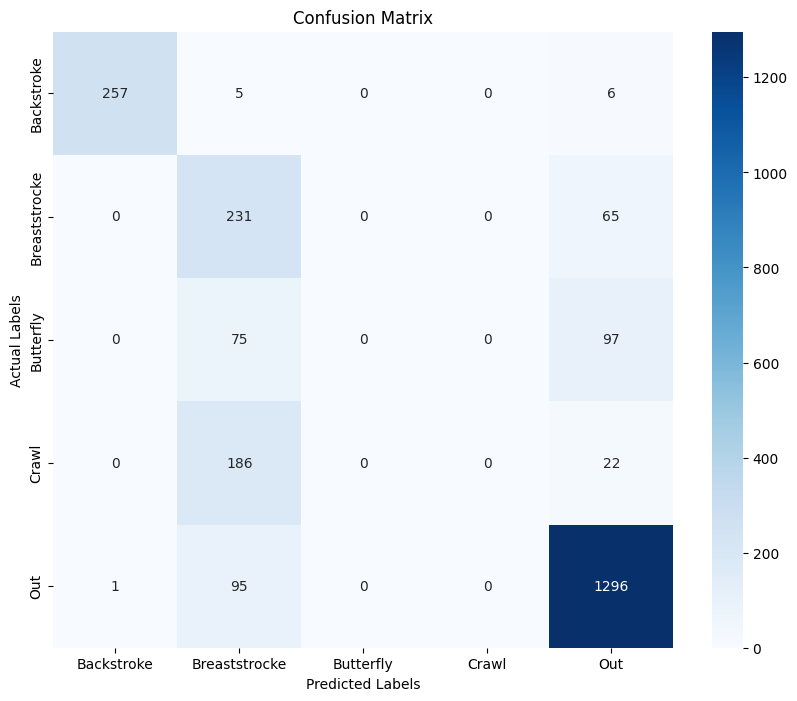

Class 0: TN=2067, FP=1, FN=11, TP=257
Class 1: TN=1679, FP=361, FN=65, TP=231
Class 2: TN=2164, FP=0, FN=172, TP=0
Class 3: TN=2128, FP=0, FN=208, TP=0
Class 4: TN=754, FP=190, FN=96, TP=1296


In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix


from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow_model_optimization as tfmot

# Define the input and output columns
features = ["norm_Acc", "norm_Gyr",
            "FusedAccX", "FusedAccY", "FusedAccZ",
            "FusedGyrX", "FusedGyrY", "FusedGyrZ",
            "FusedOrientationX", "FusedOrientationY", "FusedOrientationZ", "FusedOrientationW",
            "Magnitude", "NormalizedAccX", "NormalizedAccY", "NormalizedAccZ"]

dA = pd.read_csv('fused_data.csv', sep=";")
dT = pd.read_csv('fused_data_don.csv', sep=";")
#dR = pd.read_csv('fused_data_dAl.csv', sep=";")

# Concatenate the two DataFrames along the rows (vertically)
train_data = pd.concat([dA, dT], ignore_index=True)
# Concatenate the two DataFrames along the rows (vertically)
#combined_data2 = pd.concat([df1, df2], ignore_index=True)

#train_data = pd.read_csv('fused_data.csv', sep=";")
#test_data = pd.read_csv('csv_set2.csv', sep=";")
test_data = pd.read_csv('Tristan4nage_july.csv', sep =";")

def norm(f_vals):

    #Calcul de la norme d'un vecteur à partir de ses composantes.

    # Calcule la norme à partir des composantes du vecteur.
    norm = np.sqrt(np.sum(np.abs(f_vals)**2))

    return norm

test_data["AccX"] = test_data["AccX"].str.replace(',', '.')
test_data["AccY"] = test_data["AccY"].str.replace(',', '.')
test_data["AccZ"] = test_data["AccZ"].str.replace(',', '.')

# Enregistre les résultats dans un nouveau fichier CSV.
test_data.to_csv('replace.csv', index=False)


test_data["AccX"] = test_data["AccX"].astype(float)
test_data["AccY"] = test_data["AccY"].astype(float)
test_data["AccZ"] = test_data["AccZ"].astype(float)

# Sélectionne les colonnes à utiliser pour le calcul de la norme.
cols_Acc = ['AccX', 'AccY', 'AccZ']
cols_Gyr = ['GyrX', 'GyrY', 'GyrZ']

# Calcule la norme pour chaque ligne du DataFrame.
test_data['norm_Acc'] = test_data[cols_Acc].apply(lambda x: norm(x), axis=1)
test_data['norm_Gyr'] = test_data[cols_Gyr].apply(lambda x: norm(x), axis=1)

# Enregistre les résultats dans un nouveau fichier CSV.
test_data.to_csv('norms_Acc_2106.csv', index=False)
#df.to_csv('norms_Gyr.csv', index=False)
test_data.head()


# Extract the acceleration components in X, Y, and Z directions
acc_x = test_data['AccX']
acc_y = test_data['AccY']
acc_z = test_data['AccZ']

# Calculate the magnitude of acceleration using the Euclidean norm formula
magnitude = np.sqrt(acc_x**2 + acc_y**2 + acc_z**2)

# Normalize the acceleration components by dividing each component by the magnitude
normalized_acc_x = acc_x / magnitude
normalized_acc_y = acc_y / magnitude
normalized_acc_z = acc_z / magnitude

# Add the magnitude and normalized acceleration columns to the DataFrame
test_data['Magnitude'] = magnitude
test_data['NormalizedAccX'] = normalized_acc_x
test_data['NormalizedAccY'] = normalized_acc_y
test_data['NormalizedAccZ'] = normalized_acc_z

# Print the updated DataFrame
#print(df.head())

test_data.to_csv('updated_data1.csv', index=False)
test_data.head()

# convert time values to numeric values
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'], format='%H:%M:%S.%f').astype(int) / 10**9

# print the updated dataframe
print(test_data.head())

time = test_data["Timestamp"].values
acceleration = test_data[["AccX", "AccY", "AccZ"]].values.astype(float)
gyroscope = test_data[["GyrX", "GyrY", "GyrZ"]].values.astype(float)

# Initialize variables
q = np.array([1, 0, 0, 0])
integral_error = np.array([0, 0, 0])

# Create empty lists to store the fused data
fused_acceleration = []
fused_gyroscope = []
fused_orientation = []

def q_mult(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1*w2 - x1*x2 - y1*y2 - z1*z2
    x = w1*x2 + x1*w2 + y1*z2 - z1*y2
    y = w1*y2 - x1*z2 + y1*w2 + z1*x2
    z = w1*z2 + x1*y2 - y1*x2 + z1*w2
    return np.array([w, x, y, z])

def q_conj(q):
    """ Calcule le conjugé d'un quaternion """
    w, x, y, z = q
    return np.array([w, -x, -y, -z])

# Loop through each data point
for i in range(len(test_data)):
    # Normalize acceleration values
    norm_acc = np.linalg.norm(acceleration[i])
    if norm_acc == 0:
        acceleration[i] = [0, 0, 0]
    else:
        acceleration[i] /= norm_acc

    # Normalize gyroscope values
    norm_gyro = np.linalg.norm(gyroscope[i])
    if norm_gyro == 0:
        gyroscope[i] = [0, 0, 0]
    else:
        gyroscope[i] /= norm_gyro

    # Convert gyroscope values to radians per second
    gyroscope_rad = np.radians(gyroscope[i])

    # Calculate the predicted orientation using the gyroscope data
    q_predicted = q + 0.5 * q_mult(q, np.hstack([0, gyroscope_rad])) * (time[i] - time[i-1])
    q_predicted /= np.linalg.norm(q_predicted)
    #print(time[i] - time[i-1])
    #print(time[i])
    # Calculate the error between the predicted orientation and the measured orientation
    q_measured = np.array([np.sqrt(0.5), 0, np.sqrt(0.5), 0])
    q_error = q_mult(q_predicted, q_conj(q_measured))

    # Integrate the error over time to get the integral error
    integral_error = integral_error.astype('float64')
    integral_error += q_error[1:] * (time[i] - time[i-1])

    # Calculate the correction term using the integral error
    correction = np.hstack([0, 2 * 1 * integral_error])

    # Apply the correction term to the predicted orientation to get the corrected orientation
    q_corrected = q_mult(q_predicted, correction)
    q_corrected /= np.linalg.norm(q_corrected)

    # Use the accelerometer data to further correct the orientation
    gravity = np.array([0, 0, -1])
    acceleration_norm = np.linalg.norm(acceleration[i])
    if acceleration_norm != 0:
        acceleration_normalized = acceleration[i] / acceleration_norm
        error = np.cross(acceleration_normalized, gravity)
        correction_acc = np.hstack([1, error])
        q_corrected = q_mult(q_corrected, correction_acc)
        q_corrected /= np.linalg.norm(q_corrected)


    # Store the corrected orientation in a list
    fused_orientation.append(q_corrected)

    # Use the rotate method to get the fused acceleration and gyroscope data
    r = R.from_quat(q_corrected)
    fused_acceleration.append(r.apply(acceleration[i]))
    fused_gyroscope.append(r.apply(gyroscope[i]))

# Ajouter les données fusionnées au DataFrame
test_data["FusedAccX"], test_data["FusedAccY"], test_data["FusedAccZ"] = np.array(fused_acceleration).T
test_data["FusedGyrX"], test_data["FusedGyrY"], test_data["FusedGyrZ"] = np.array(fused_gyroscope).T
test_data["FusedOrientationX"], test_data["FusedOrientationY"], test_data["FusedOrientationZ"], test_data["FusedOrientationW"] = np.array(fused_orientation).T

# Save the updated dataframe to a new CSV file
test_data.to_csv("fused_data_set2.csv", sep=";", index=False)

print(train_data.columns)
print(test_data.columns)

# Combine train and test data for consistent scaling
combined_data = pd.concat([train_data, test_data], axis=0)

X_data = combined_data[features]
y_data = combined_data['Swim_class'].values

le = LabelEncoder()
y_data = le.fit_transform(y_data)

scaler = MinMaxScaler()
X_data = scaler.fit_transform(X_data)

# Define window size and stride
window_size = 10
stride = 2

# Create rolling windows of the input data
input_sequences = []
output_labels = []
for i in range(0, len(X_data) - window_size, stride):
    input_sequences.append(X_data[i:i+window_size])
    output_labels.append(y_data[i+window_size])

# Convert input sequences and labels to numpy arrays
input_sequences = np.array(input_sequences)
output_labels = np.array(output_labels)

# Reshape input sequences to match LSTM input shape
input_sequences = np.reshape(input_sequences, (input_sequences.shape[0], window_size, len(features)))

# Convert output labels to one-hot encoded format
output_labels = to_categorical(output_labels)

# Split into train and test sets
X_train = input_sequences[:len(train_data)]
y_train = output_labels[:len(train_data)]
X_test = input_sequences[len(test_data):]
y_test = output_labels[len(test_data):]

# Define a custom QuantizeConfig for the LSTM layer
class LSTMQuantizeConfig(tfmot.quantization.keras.QuantizeConfig):
    def get_weights_and_quantizers(self, layer):
        return [(layer.kernel, tfmot.quantization.keras.quantizers.MovingAverageQuantizer(num_bits=8, symmetric=True, narrow_range=False, per_axis=False))]

    def get_activations_and_quantizers(self, layer):
        return {
            'cell_activation': tfmot.quantization.keras.quantizers.LastValueQuantizer(
                num_bits=8,
                per_axis=False,
                symmetric=False
            )
        }

    def set_quantize_weights(self, layer, quantize_weights):
        layer.kernel = quantize_weights[0]


    def set_quantize_activations(self, layer, quantize_activations):
        layer.cell.activation = quantize_activations['cell_activation']

    def get_config(self):
        return {}

    def get_output_quantizers(self, layer):
        return [tfmot.quantization.keras.quantizers.MovingAverageQuantizer(num_bits=8, symmetric=True, narrow_range=False, per_axis=False)]

# Annotate the LSTM layers for quantization
quantize_annotate_layer = tfmot.quantization.keras.quantize_annotate_layer
annotated_lstm_layer1 = quantize_annotate_layer(LSTM(10, return_sequences=True, input_shape=(window_size, len(features))), LSTMQuantizeConfig())
annotated_lstm_layer2 = quantize_annotate_layer(LSTM(3, input_shape=(window_size, len(features))), LSTMQuantizeConfig())

# Annotate the Dense layers for quantization
annotated_dense_layer1 = quantize_annotate_layer(Dense(8, activation='relu',kernel_regularizer=regularizers.l2(0.04)), LSTMQuantizeConfig())
annotated_dense_layer2 = quantize_annotate_layer(Dense(5, activation='softmax'), LSTMQuantizeConfig())

# Create the model with annotated layers
model_Windows = Sequential([
    annotated_lstm_layer1,
    Dropout(0.5),
    annotated_lstm_layer2,
    Dropout(0.2),
    annotated_dense_layer1,
    Dropout(0.2),
    annotated_dense_layer2
])

# Compile
model_Windows.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model_Windows.fit(X_train, y_train, epochs=50, batch_size=15, validation_data=(X_test, y_test), verbose=2)

# Evaluate the model on the test set
_, accuracy = model_Windows.evaluate(X_test, y_test, verbose=0)
print('Accuracy_quantization: %.2f' % (accuracy*100))

# Make predictions on the test set
y_pred = model_Windows.predict(X_test)

# Get the class predictions
class_predictions = np.argmax(y_pred, axis=1)

# Decode the class predictions and actual labels
class_labels = le.inverse_transform(class_predictions)
actual_labels = le.inverse_transform(np.argmax(y_test, axis=1))

# Create the confusion matrix
conf_matrix = confusion_matrix(actual_labels, class_labels)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.show()

# Extracting True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN) for each class
TP = np.diag(conf_matrix)
FP = np.sum(conf_matrix, axis=0) - TP
FN = np.sum(conf_matrix, axis=1) - TP
TN = np.sum(conf_matrix) - (TP + FP + FN)

# Displaying the values for each class
for i in range(5):  # Assuming 5 classes
    print(f"Class {i}: TN={TN[i]}, FP={FP[i]}, FN={FN[i]}, TP={TP[i]}")

## **Version without rolling windows and with quantization**

      Timestamp    Fix Lat Lon Alt  pAcc  Mag Speed  sAcc Heading  ...   GyrX  \
0 -2.208951e+09  False   0   0   0     0    0     0     0       0  ... -50540   
1 -2.208951e+09  False   0   0   0     0    0     0     0       0  ... -31430   
2 -2.208951e+09  False   0   0   0     0    0     0     0       0  ...  17360   
3 -2.208951e+09  False   0   0   0     0    0     0     0       0  ... -25900   
4 -2.208951e+09  False   0   0   0     0    0     0     0       0  ...  92050   

     GyrY   GyrZ  Swim_class     norm_Acc       norm_Gyr    Magnitude  \
0 -117180 -27860         Out  1112.122557  130620.150054  1112.122557   
1  -64890 -59640         Out   705.142439   93570.757184   705.142439   
2   29470 -23170         Out   964.821572   41312.218532   964.821572   
3   -5670  -2450         Out   741.636505   26626.329075   741.636505   
4    9870  35700         Out  1107.692199   99222.524660  1107.692199   

  NormalizedAccX  NormalizedAccY  NormalizedAccZ  
0       0.649864       

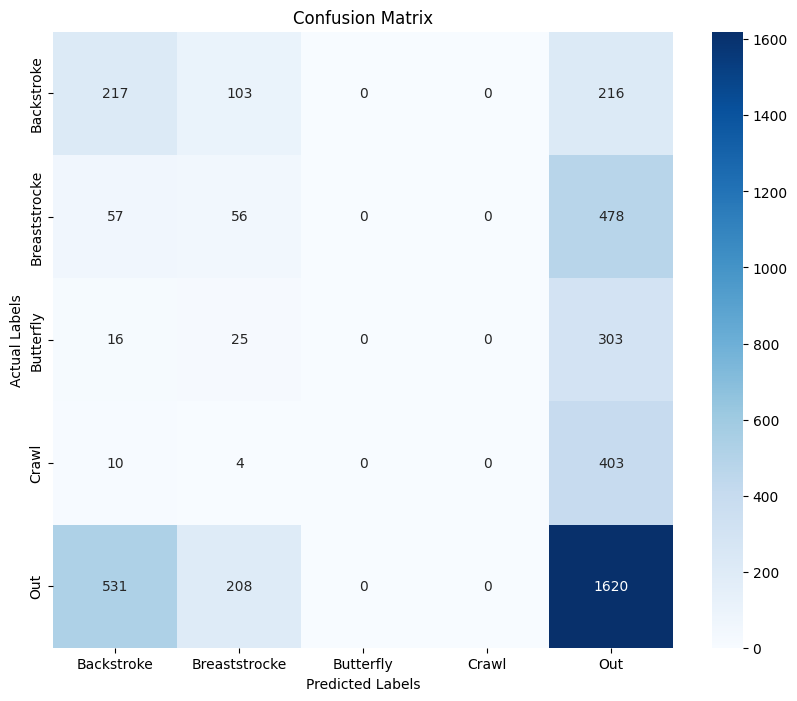

Class 0: TN=3097, FP=614, FN=319, TP=217
Class 1: TN=3316, FP=340, FN=535, TP=56
Class 2: TN=3903, FP=0, FN=344, TP=0
Class 3: TN=3830, FP=0, FN=417, TP=0
Class 4: TN=488, FP=1400, FN=739, TP=1620


'\n# make predictions on new data\ntest_data = np.array([[2175, 871, -0.83, -0.53, 0.1, -0.3, 0.2, 0.9, -0.05, -0.84, 0.4, 0.2, 1, 1, 1, 1], #backstroke\n                      [2481, 2187, 0.5, 0.6, 0.5, -0.4, 0.8, -0.3, -0.006, -0.7, 0.4, 0.4, 1, 1, 1, 1], #breaststroke\n                      [2020, 7842, -0.2, 0.1, -0.9, 0.3, -0.9, -0.2, 0.1, -0.1, 0.3, 0.88, 1, 1, 1, 1]]) #butterfly\ntest_data = scaler.transform(test_data)\ntest_data = test_data.reshape(test_data.shape[0], 1, test_data.shape[1])\npredictions = model_quantization.predict(test_data)\nprint(predictions)\n\n# get the class predictions\nclass_predictions = np.argmax(predictions, axis=1)\n\n# decode the class predictions\nclass_labels = le.inverse_transform(class_predictions)\n\n# print the class predictions\nprint(class_labels)\n'

In [10]:
# define the input and output columns
features = ["norm_Acc", "norm_Gyr",
            "FusedAccX", "FusedAccY","FusedAccZ",
            "FusedGyrX","FusedGyrY", "FusedGyrZ",
            "FusedOrientationX", "FusedOrientationY", "FusedOrientationZ", "FusedOrientationW",
            "Magnitude", "NormalizedAccX", "NormalizedAccY", "NormalizedAccZ" ]

dA = pd.read_csv('fused_data.csv', sep=";")
dT = pd.read_csv('fused_data_don.csv', sep=";")
# Concatenate the two DataFrames along the rows (vertically)
train_data = pd.concat([dA, dT], ignore_index=True)
# Concatenate the two DataFrames along the rows (vertically)
#combined_data2 = pd.concat([df1, df2], ignore_index=True)

#train_data = pd.read_csv('fused_data.csv', sep =";")
test_data = pd.read_csv('Tristan4nage_july.csv', sep =";")

def norm(f_vals):

    #Calcul de la norme d'un vecteur à partir de ses composantes.

    # Calcule la norme à partir des composantes du vecteur.
    norm = np.sqrt(np.sum(np.abs(f_vals)**2))

    return norm

test_data["AccX"] = test_data["AccX"].str.replace(',', '.')
test_data["AccY"] = test_data["AccY"].str.replace(',', '.')
test_data["AccZ"] = test_data["AccZ"].str.replace(',', '.')

# Enregistre les résultats dans un nouveau fichier CSV.
test_data.to_csv('replace.csv', index=False)


test_data["AccX"] = test_data["AccX"].astype(float)
test_data["AccY"] = test_data["AccY"].astype(float)
test_data["AccZ"] = test_data["AccZ"].astype(float)


# Sélectionne les colonnes à utiliser pour le calcul de la norme.
cols_Acc = ['AccX', 'AccY', 'AccZ']
cols_Gyr = ['GyrX', 'GyrY', 'GyrZ']

# Calcule la norme pour chaque ligne du DataFrame.
test_data['norm_Acc'] = test_data[cols_Acc].apply(lambda x: norm(x), axis=1)
test_data['norm_Gyr'] = test_data[cols_Gyr].apply(lambda x: norm(x), axis=1)

# Enregistre les résultats dans un nouveau fichier CSV.
test_data.to_csv('norms_Acc_2106.csv', index=False)
#df.to_csv('norms_Gyr.csv', index=False)
test_data.head()

# Extract the acceleration components in X, Y, and Z directions
acc_x = test_data['AccX']
acc_y = test_data['AccY']
acc_z = test_data['AccZ']

# Calculate the magnitude of acceleration using the Euclidean norm formula
magnitude = np.sqrt(acc_x**2 + acc_y**2 + acc_z**2)

# Normalize the acceleration components by dividing each component by the magnitude
normalized_acc_x = acc_x / magnitude
normalized_acc_y = acc_y / magnitude
normalized_acc_z = acc_z / magnitude

# Add the magnitude and normalized acceleration columns to the DataFrame
test_data['Magnitude'] = magnitude
test_data['NormalizedAccX'] = normalized_acc_x
test_data['NormalizedAccY'] = normalized_acc_y
test_data['NormalizedAccZ'] = normalized_acc_z

# Print the updated DataFrame
#print(df.head())

test_data.to_csv('updated_data1.csv', index=False)
test_data.head()

# Sélectionne les colonnes à utiliser pour le calcul de la norme.
cols_Acc = ['AccX', 'AccY', 'AccZ']
cols_Gyr = ['GyrX', 'GyrY', 'GyrZ']

# Calcule la norme pour chaque ligne du DataFrame.
test_data['norm_Acc'] = test_data[cols_Acc].apply(lambda x: norm(x), axis=1)
test_data['norm_Gyr'] = test_data[cols_Gyr].apply(lambda x: norm(x), axis=1)

# Enregistre les résultats dans un nouveau fichier CSV.
test_data.to_csv('norms_Acc_set2.csv', index=False)
#df.to_csv('norms_Gyr.csv', index=False)
test_data.head()

# convert time values to numeric values
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'], format='%H:%M:%S.%f').astype(int) / 10**9

# print the updated dataframe
print(test_data.head())

time = test_data["Timestamp"].values
acceleration = test_data[["AccX", "AccY", "AccZ"]].values.astype(float)
gyroscope = test_data[["GyrX", "GyrY", "GyrZ"]].values.astype(float)

# Initialize variables
q = np.array([1, 0, 0, 0])
integral_error = np.array([0, 0, 0])

# Create empty lists to store the fused data
fused_acceleration = []
fused_gyroscope = []
fused_orientation = []

def q_mult(q1, q2):
    w1, x1, y1, z1 = q1
    w2, x2, y2, z2 = q2
    w = w1*w2 - x1*x2 - y1*y2 - z1*z2
    x = w1*x2 + x1*w2 + y1*z2 - z1*y2
    y = w1*y2 - x1*z2 + y1*w2 + z1*x2
    z = w1*z2 + x1*y2 - y1*x2 + z1*w2
    return np.array([w, x, y, z])

def q_conj(q):
    """ Calcule le conjugé d'un quaternion """
    w, x, y, z = q
    return np.array([w, -x, -y, -z])

# Loop through each data point
for i in range(len(test_data)):
    # Normalize acceleration values
    norm_acc = np.linalg.norm(acceleration[i])
    if norm_acc == 0:
        acceleration[i] = [0, 0, 0]
    else:
        acceleration[i] /= norm_acc

    # Normalize gyroscope values
    norm_gyro = np.linalg.norm(gyroscope[i])
    if norm_gyro == 0:
        gyroscope[i] = [0, 0, 0]
    else:
        gyroscope[i] /= norm_gyro

    # Convert gyroscope values to radians per second
    gyroscope_rad = np.radians(gyroscope[i])

    # Calculate the predicted orientation using the gyroscope data
    q_predicted = q + 0.5 * q_mult(q, np.hstack([0, gyroscope_rad])) * (time[i] - time[i-1])
    q_predicted /= np.linalg.norm(q_predicted)
    #print(time[i] - time[i-1])
    #print(time[i])
    # Calculate the error between the predicted orientation and the measured orientation
    q_measured = np.array([np.sqrt(0.5), 0, np.sqrt(0.5), 0])
    q_error = q_mult(q_predicted, q_conj(q_measured))

    # Integrate the error over time to get the integral error
    integral_error = integral_error.astype('float64')
    integral_error += q_error[1:] * (time[i] - time[i-1])

    # Calculate the correction term using the integral error
    correction = np.hstack([0, 2 * 1 * integral_error])

    # Apply the correction term to the predicted orientation to get the corrected orientation
    q_corrected = q_mult(q_predicted, correction)
    q_corrected /= np.linalg.norm(q_corrected)

    # Use the accelerometer data to further correct the orientation
    gravity = np.array([0, 0, -1])
    acceleration_norm = np.linalg.norm(acceleration[i])
    if acceleration_norm != 0:
        acceleration_normalized = acceleration[i] / acceleration_norm
        error = np.cross(acceleration_normalized, gravity)
        correction_acc = np.hstack([1, error])
        q_corrected = q_mult(q_corrected, correction_acc)
        q_corrected /= np.linalg.norm(q_corrected)


    # Store the corrected orientation in a list
    fused_orientation.append(q_corrected)

    # Use the rotate method to get the fused acceleration and gyroscope data
    r = R.from_quat(q_corrected)
    fused_acceleration.append(r.apply(acceleration[i]))
    fused_gyroscope.append(r.apply(gyroscope[i]))

# Ajouter les données fusionnées au DataFrame
test_data["FusedAccX"], test_data["FusedAccY"], test_data["FusedAccZ"] = np.array(fused_acceleration).T
test_data["FusedGyrX"], test_data["FusedGyrY"], test_data["FusedGyrZ"] = np.array(fused_gyroscope).T
test_data["FusedOrientationX"], test_data["FusedOrientationY"], test_data["FusedOrientationZ"], test_data["FusedOrientationW"] = np.array(fused_orientation).T

# Save the updated dataframe to a new CSV file
test_data.to_csv("fused_data_set2.csv", sep=";", index=False)

print(train_data.columns)
print(test_data.columns)

X_train = train_data[features]
y_train = train_data['Swim_class'].values

X_test = test_data[features]
y_test = test_data['Swim_class'].values

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(X_train.shape[1])
#print(X_train.shape[2])

# Annotate the LSTM layers for quantization
quantize_annotate_layer = tfmot.quantization.keras.quantize_annotate_layer
annotated_lstm_layer1 = quantize_annotate_layer(LSTM(10, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])), LSTMQuantizeConfig())
annotated_lstm_layer2 = quantize_annotate_layer(LSTM(3, input_shape=(X_train.shape[1], X_train.shape[2])), LSTMQuantizeConfig())

# Annotate the Dense layers for quantization
annotated_dense_layer1 = quantize_annotate_layer(Dense(8, activation='relu',kernel_regularizer=regularizers.l2(0.02)), LSTMQuantizeConfig())
annotated_dense_layer2 = quantize_annotate_layer(Dense(5, activation='softmax'), LSTMQuantizeConfig())

# Create the model with annotated layers
model_quantization = tf.keras.Sequential([
    annotated_lstm_layer1,
    Dropout(0.2),
    annotated_lstm_layer2,
    Dropout(0.2),
    annotated_dense_layer1,
    Dropout(0.2),
    annotated_dense_layer2
])

# Compile
model_quantization.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model_quantization.fit(X_train, y_train, epochs=50, batch_size=15, validation_data=(X_test, y_test), verbose=2)

# evaluate the model on the test set
_, accuracy = model_quantization.evaluate(X_test, y_test, verbose=0)
print('Accuracy_quantization: %.2f' % (accuracy*100))

# Make predictions on the test set
y_pred = model_quantization.predict(X_test)

# Get the class predictions
class_predictions = np.argmax(y_pred, axis=1)

# Decode the class predictions and actual labels
class_labels = le.inverse_transform(class_predictions)
actual_labels = le.inverse_transform(np.argmax(y_test, axis=1))

# Create the confusion matrix
conf_matrix = confusion_matrix(actual_labels, class_labels)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.show()


# Extracting True Positives (TP), False Positives (FP), True Negatives (TN), and False Negatives (FN) for each class
TP = np.diag(conf_matrix)
FP = np.sum(conf_matrix, axis=0) - TP
FN = np.sum(conf_matrix, axis=1) - TP
TN = np.sum(conf_matrix) - (TP + FP + FN)

# Displaying the values for each class
for i in range(5):  # Assuming 5 classes
    print(f"Class {i}: TN={TN[i]}, FP={FP[i]}, FN={FN[i]}, TP={TP[i]}")

#new_data = pd.read_csv('fused_data_csv_set2.csv')

#predictions = model_quantization.predict(new_data)
"""
# make predictions on new data
test_data = np.array([[2175, 871, -0.83, -0.53, 0.1, -0.3, 0.2, 0.9, -0.05, -0.84, 0.4, 0.2, 1, 1, 1, 1], #backstroke
                      [2481, 2187, 0.5, 0.6, 0.5, -0.4, 0.8, -0.3, -0.006, -0.7, 0.4, 0.4, 1, 1, 1, 1], #breaststroke
                      [2020, 7842, -0.2, 0.1, -0.9, 0.3, -0.9, -0.2, 0.1, -0.1, 0.3, 0.88, 1, 1, 1, 1]]) #butterfly
test_data = scaler.transform(test_data)
test_data = test_data.reshape(test_data.shape[0], 1, test_data.shape[1])
predictions = model_quantization.predict(test_data)
print(predictions)

# get the class predictions
class_predictions = np.argmax(predictions, axis=1)

# decode the class predictions
class_labels = le.inverse_transform(class_predictions)

# print the class predictions
print(class_labels)
"""


In [11]:
"""
import numpy as np
import matplotlib.pyplot as plt

def plot_learning_curve(model_quantization, X_train, y_train, train_sizes, cv):
    train_scores = []
    test_scores = []

    for size in train_sizes:
        subset_size = int(len(X_train) * size)
        X_subset = X_train[:subset_size]
        y_subset = y_train[:subset_size]

        model_quantization.fit(X_subset, y_subset, epochs=50, batch_size=15, verbose=0)
        train_loss, train_accuracy = model_quantization.evaluate(X_subset, y_subset, verbose=0)
        test_loss, test_accuracy = model_quantization.evaluate(X_test, y_test, verbose=0)

        train_scores.append(train_accuracy)
        test_scores.append(test_accuracy)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores, label="Training score", color="blue")
    plt.plot(train_sizes, test_scores, label="Validation score", color="red")

    plt.xlabel("Number of training examples")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.title("Learning Curve")
    plt.grid()
    plt.show()

# Define the train_sizes and cv values for the learning curve
train_sizes = np.linspace(0.1, 1.0, 10)
cv = 5

# Plot the learning curve for the quantized model
plot_learning_curve(model_quantization, X_train, y_train, train_sizes, cv)

"""

'\nimport numpy as np\nimport matplotlib.pyplot as plt\n\ndef plot_learning_curve(model_quantization, X_train, y_train, train_sizes, cv):\n    train_scores = []\n    test_scores = []\n\n    for size in train_sizes:\n        subset_size = int(len(X_train) * size)\n        X_subset = X_train[:subset_size]\n        y_subset = y_train[:subset_size]\n\n        model_quantization.fit(X_subset, y_subset, epochs=50, batch_size=15, verbose=0)\n        train_loss, train_accuracy = model_quantization.evaluate(X_subset, y_subset, verbose=0)\n        test_loss, test_accuracy = model_quantization.evaluate(X_test, y_test, verbose=0)\n\n        train_scores.append(train_accuracy)\n        test_scores.append(test_accuracy)\n\n    plt.figure(figsize=(8, 6))\n    plt.plot(train_sizes, train_scores, label="Training score", color="blue")\n    plt.plot(train_sizes, test_scores, label="Validation score", color="red")\n\n    plt.xlabel("Number of training examples")\n    plt.ylabel("Accuracy")\n    plt.legend

In [12]:
pip install onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 44.8 MB/s eta 0:00:00


In [13]:
pip install tf2onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 451.2/451.2 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.5.26
    Uninstalling flatbuffers-23.5.26:
      Successfully uninstalled flatbuffers-23.5.26
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.25.2 which is incompatible.


In [14]:
pip install onnxmltools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.3/292.3 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 10.3 MB/s eta 0:00:00


In [15]:
pip install tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 26.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 56.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 22.0 MB/s eta 0:00:00
  Created wheel for pyyaml: filename=P

**ONNX model with rolling windows**

In [16]:
import onnx
from tf2onnx import convert

# Convert the Keras quantized model to ONNX
onnx_model, _ = convert.from_keras(model_Windows)

# Save the ONNX model to a file
onnx_file_path = "Windows_lstm_model.onnx"
onnx.save_model(onnx_model, onnx_file_path)

print("Quantized model exported to ONNX successfully.")


Quantized model exported to ONNX successfully.


**ONNX model with quantization**

In [17]:
import onnx
from tf2onnx import convert

# Convert the Keras quantized model to ONNX
onnx_model, _ = convert.from_keras(model_quantization)

# Save the ONNX model to a file
onnx_file_path = "quantized_lstm_model.onnx"
onnx.save_model(onnx_model, onnx_file_path)

print("Quantized model exported to ONNX successfully.")

Quantized model exported to ONNX successfully.


**CONFUSION MATRIX for Rolling Windows**



In [18]:
"""
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Reshape the input sequences
input_sequences = np.reshape(input_sequences, (input_sequences.shape[0], window_size, len(features)))
#input_sequences = np.reshape(input_sequences, (input_sequences.shape[0], 20, 16))
X_test = X_test.reshape(X_test.shape[0], window_size, X_test.shape[1])

# Make predictions on the test set
y_pred = model_Windows.predict(X_test)

# Get the class predictions
class_predictions = np.argmax(y_pred, axis=1)

# Decode the class predictions and actual labels
class_labels = le.inverse_transform(class_predictions)
actual_labels = le.inverse_transform(np.argmax(y_test, axis=1))

# Create the confusion matrix
conf_matrix = confusion_matrix(actual_labels, class_labels)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.show()
"""


'\nfrom sklearn.metrics import confusion_matrix\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\n# Reshape the input sequences\ninput_sequences = np.reshape(input_sequences, (input_sequences.shape[0], window_size, len(features)))\n#input_sequences = np.reshape(input_sequences, (input_sequences.shape[0], 20, 16))\nX_test = X_test.reshape(X_test.shape[0], window_size, X_test.shape[1])\n\n# Make predictions on the test set\ny_pred = model_Windows.predict(X_test)\n\n# Get the class predictions\nclass_predictions = np.argmax(y_pred, axis=1)\n\n# Decode the class predictions and actual labels\nclass_labels = le.inverse_transform(class_predictions)\nactual_labels = le.inverse_transform(np.argmax(y_test, axis=1))\n\n# Create the confusion matrix\nconf_matrix = confusion_matrix(actual_labels, class_labels)\n\n# Visualize the confusion matrix\nplt.figure(figsize=(10, 8))\nsns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabel

In [19]:
#Confusion Matrix

from sklearn.metrics import confusion_matrix

# make predictions on the test set
y_pred = model_Windows.predict(X_test)

# get the class predictions
class_predictions = np.argmax(y_pred, axis=1)

# decode the class predictions
class_labels = le.inverse_transform(class_predictions)

# get the actual class labels
actual_labels = le.inverse_transform(np.argmax(y_test, axis=1))

# create the confusion matrix
conf_matrix = confusion_matrix(actual_labels, class_labels)

print(conf_matrix)

#print(class_predictions)
#print(class_labels)

133/133 [==============================] - 3s 6ms/step
[[   0  431    0    0  105]
 [   0   11    0    0  580]
 [   0   10    0    0  334]
 [   0    4    0    0  413]
 [   0   90    0    0 2269]]


**Recall for Rolling Windows**



In [20]:
#Recall Metric

# define the recall metric
recall = tf.keras.metrics.Recall()

# compute the recall on a batch of predictions and ground truth labels
y_pred = model_Windows.predict(X_test)
recall.update_state(y_test, y_pred)

# get the recall score
score = recall.result().numpy()

print("Recall score:", score)


133/133 [==============================] - 1s 6ms/step
Recall score: 0.0030609842


**F1 score for Rolling Windows**



In [21]:
# F1 score Metric

from sklearn.metrics import f1_score

# make predictions on test set
y_pred = model_Windows.predict(X_test)

# get class predictions
y_pred = np.argmax(y_pred, axis=1)

# calculate F1 score
f1 = f1_score(y_test.argmax(axis=1), y_pred, average='weighted')

print("F1 score:", f1)


133/133 [==============================] - 1s 7ms/step
F1 score: 0.4186391426203858


**Weights for rolling windows**

In [22]:
# get the weights of the first layer
first_layer_weights = model_Windows.layers[0].get_weights()[0]

# get the biases of the first layer
first_layer_biases = model_Windows.layers[0].get_weights()[1]

# get all the weights in the model
all_weights = model_Windows.get_weights()

print(first_layer_weights)

[[-2.62674302e-01  4.49889719e-01  5.10179341e-01  1.82122171e-01
   5.51443219e-01  2.86653489e-01 -3.95478755e-01  4.55606908e-01
   2.95613050e-01 -6.09239578e-01 -3.41846555e-01  4.15603936e-01
   2.63666481e-01 -5.62785983e-01 -3.74276906e-01 -1.68960363e-01
  -6.70693994e-01 -3.27707827e-01  1.48945794e-01 -7.55984962e-01
   2.13502213e-01 -2.70560622e-01 -3.13743085e-01  1.55035347e-01
   2.61797398e-01  3.78426343e-01  2.81347156e-01  3.64327729e-01
  -1.95408046e-01 -4.21409667e-01 -2.99189806e-01  4.53829437e-01
   2.82184780e-01  4.01728123e-01  2.35882968e-01 -3.32229048e-01
  -3.43400300e-01 -2.09475145e-01  4.17912811e-01 -8.72849524e-01]
 [-4.30281848e-01 -1.45952687e-01  3.41077179e-01  4.10061896e-01
   4.56362605e-01  8.61299276e-01 -9.76276323e-02  3.39122117e-01
  -1.36887893e-01 -3.07735652e-01 -1.27139056e+00 -7.57454872e-01
  -7.81455040e-01 -7.01002717e-01 -5.19509554e-01 -1.41605675e-01
  -2.87880749e-01 -1.10621251e-01 -2.57576466e-01  3.08119565e-01
  -1.7112

In [23]:
print(first_layer_biases)

[[ 0.20825443 -1.1684772  -0.45420402 -0.48861358  0.26135847 -0.58966005
   0.3748567   0.6626887   0.59704334 -1.1638898   1.0289319  -0.9548686
  -0.02343454  0.744698    0.8278246  -1.2383493  -0.17470607  0.05724209
   0.8668737   0.4683337   0.16219197 -0.35294837 -0.17156027  0.21103713
  -0.27888143  0.68575525 -0.13544263  0.38364717 -0.17361422 -0.0749465
   0.13997434 -1.4080216  -0.23963483 -0.24198994  0.77767825 -0.08628116
   0.27201998  0.309623    0.6729845   0.57042897]
 [ 0.01888642  0.9402362   0.9120304  -0.83854854 -0.87721527 -0.6807654
   0.31326166 -0.39183503  0.31320435 -0.70152885  0.1642625   0.42956913
   0.40950936 -0.36539164 -0.71876204 -0.45338175 -0.05381557 -0.4061918
   0.29162776  0.12708668 -0.01176983  0.36012027 -0.01203946  0.80760896
  -0.4385825  -1.4511937  -0.3593675   0.3788113   0.0118115  -0.34206885
   0.5645288   0.3684908   0.8160082  -0.5411131  -0.6699091   0.12566221
   0.02211043  1.2943323   0.05407951  0.822641  ]
 [ 0.45932356 

In [24]:
print(all_weights)

[array([[-2.62674302e-01,  4.49889719e-01,  5.10179341e-01,
         1.82122171e-01,  5.51443219e-01,  2.86653489e-01,
        -3.95478755e-01,  4.55606908e-01,  2.95613050e-01,
        -6.09239578e-01, -3.41846555e-01,  4.15603936e-01,
         2.63666481e-01, -5.62785983e-01, -3.74276906e-01,
        -1.68960363e-01, -6.70693994e-01, -3.27707827e-01,
         1.48945794e-01, -7.55984962e-01,  2.13502213e-01,
        -2.70560622e-01, -3.13743085e-01,  1.55035347e-01,
         2.61797398e-01,  3.78426343e-01,  2.81347156e-01,
         3.64327729e-01, -1.95408046e-01, -4.21409667e-01,
        -2.99189806e-01,  4.53829437e-01,  2.82184780e-01,
         4.01728123e-01,  2.35882968e-01, -3.32229048e-01,
        -3.43400300e-01, -2.09475145e-01,  4.17912811e-01,
        -8.72849524e-01],
       [-4.30281848e-01, -1.45952687e-01,  3.41077179e-01,
         4.10061896e-01,  4.56362605e-01,  8.61299276e-01,
        -9.76276323e-02,  3.39122117e-01, -1.36887893e-01,
        -3.07735652e-01, -1.2